# Classifying Heart Disease with Logistic Regression

In this project heart disease is predicted using logistic regression. The dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) and originates from the Cleveland Clinic Foundation. The dataset presented here is simplified from the original multi-class version to a binary case.

First the relevant libraries are imported and the dataset is read in:

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('heart_disease.csv')
df.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


## Exploring the Dataset

The dataset consists of `15` features and `303` observations:

In [2]:
df.shape

(303, 15)

The features can be described by:

- `age`: age in years  
- `sex`: sex (1 = male; 0 = female)
-  `cp`: chest pain type 
    - Value 1: typical angina 
    - Value 2: atypical angina 
    - Value 3: non-anginal pain 
    - Value 4: asymptomatic 
- `trestbps`: resting blood pressure (in mm Hg on admission to the hospital) 
- `chol`: serum cholestoral in mg/dl
- `fbs`: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
- `restecg`: resting electrocardiographic results
    - Value 0: normal 
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
- `thalach`: maximum heart rate achieved  
- `exang`: exercise induced angina (1 = yes; 0 = no) 
- `oldpeak`: ST depression induced by exercise relative to rest 
- `slope`: the slope of the peak exercise ST segment 
- `ca`: number of major vessels (0-3) colored by flourosopy 
- `thal`: 
    - Value 3: normal 
    - Value 6: fixed defect
    - Value 7: reversable defect 
- `present`: heart disease present (1 = yes; 0 = no)

Cases and non-cases are well distributed over the dataset as shown in the 
the distribution of the target variable `present`:

<AxesSubplot:>

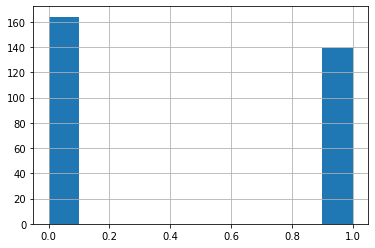

In [3]:
df['present'].hist()

The data types in the dataset are given by:

In [4]:
df.dtypes

Unnamed: 0      int64
age             int64
sex             int64
cp              int64
trestbps        int64
chol            int64
fbs             int64
restecg         int64
thalach         int64
exang           int64
oldpeak       float64
slope           int64
ca             object
thal           object
present         int64
dtype: object

The features `ca` and `thal` are `strings` and need to be converted for further analysis. However, both features have observations with unknown entries (depicted as: `?`):

In [5]:
print(df['ca'].value_counts())
print(df['thal'].value_counts())

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64
3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64


Since the number of observations is small they can be deleted without impacting prediction quality significantly:

In [6]:
df = df[df['ca'] != '?']
df = df[df['thal'] != '?']

print(df['ca'].value_counts())
print(df['thal'].value_counts())

0.0    174
1.0     65
2.0     38
3.0     20
Name: ca, dtype: int64
3.0    164
7.0    115
6.0     18
Name: thal, dtype: int64


Consequently, the dataset is now reduced to `297` observations:

In [7]:
df.shape

(297, 15)

Now, the aforementioned features are converted with an intermediary conversion to `float` to account for invalid literal in strings:

In [8]:
df = df.astype({'ca':'float', 'thal':'float'})
df = df.astype({'ca':'int8', 'thal':'int8'})
df.dtypes

Unnamed: 0      int64
age             int64
sex             int64
cp              int64
trestbps        int64
chol            int64
fbs             int64
restecg         int64
thalach         int64
exang           int64
oldpeak       float64
slope           int64
ca               int8
thal             int8
present         int64
dtype: object

There are no missing values in the dataset:

In [9]:
df.isna().sum()

Unnamed: 0    0
age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope         0
ca            0
thal          0
present       0
dtype: int64

The features `cp`, `restecg` and `thal` are categorical and are one-hot encoded for further analysis:

In [10]:
categorical_features = ['cp','restecg','thal']

for feature in categorical_features:
    dummies = pd.get_dummies(df[feature], prefix = feature)
    df = pd.concat([df,dummies], axis = 1)
    df.drop(labels = feature, axis = 1, inplace = True)

df.head()    

,Unnamed: 0,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,...,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
0,1,63,1,145,233,1,150,0,2.3,3,...,1,0,0,0,0,0,1,0,1,0
1,2,67,1,160,286,0,108,1,1.5,2,...,0,0,0,1,0,0,1,1,0,0
2,3,67,1,120,229,0,129,1,2.6,2,...,0,0,0,1,0,0,1,0,0,1
3,4,37,1,130,250,0,187,0,3.5,3,...,0,0,1,0,1,0,0,1,0,0
4,5,41,0,130,204,0,172,0,1.4,1,...,0,1,0,0,0,0,1,1,0,0


Descriptive statistics show no signs of problems in the dataset regarding minimum and maximum values or significantly skewed distributions:

In [11]:
df.describe()

,Unnamed: 0,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,...,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,...,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,150.673401,54.542088,0.676768,131.693603,247.350168,0.144781,149.599327,0.326599,1.055556,1.602694,...,0.077441,0.164983,0.279461,0.478114,0.494949,0.013468,0.491582,0.552189,0.060606,0.387205
std,87.323283,9.049736,0.468500,17.762806,51.997583,0.352474,22.941562,0.469761,1.166123,0.618187,...,0.267741,0.371792,0.449492,0.500364,0.500818,0.115462,0.500773,0.498108,0.239009,0.487933
min,1.000000,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,48.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,150.000000,56.000000,1.000000,130.000000,243.000000,0.000000,153.000000,0.000000,0.800000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,226.000000,61.000000,1.000000,140.000000,276.000000,0.000000,166.000000,1.000000,1.600000,2.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,302.000000,77.000000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The *pearson* correlation of the features can be shown visually:

<AxesSubplot:>

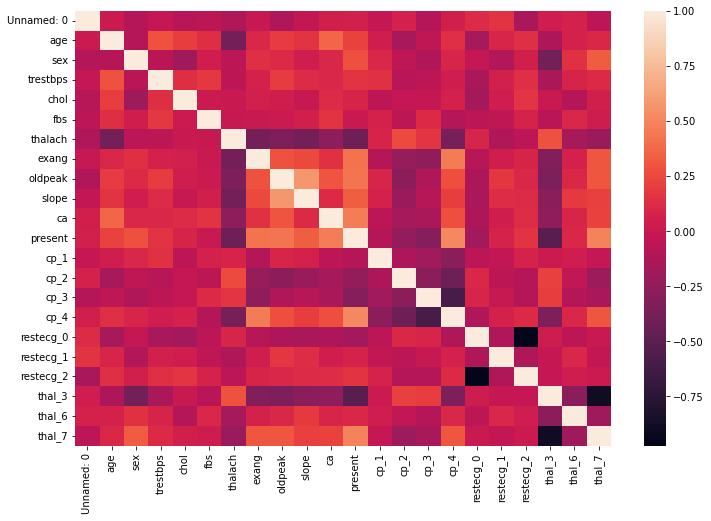

In [12]:
pearsons = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(pearsons)

A better observability is given by restricting the absolute output to a threshold of `0.4`:

<AxesSubplot:>

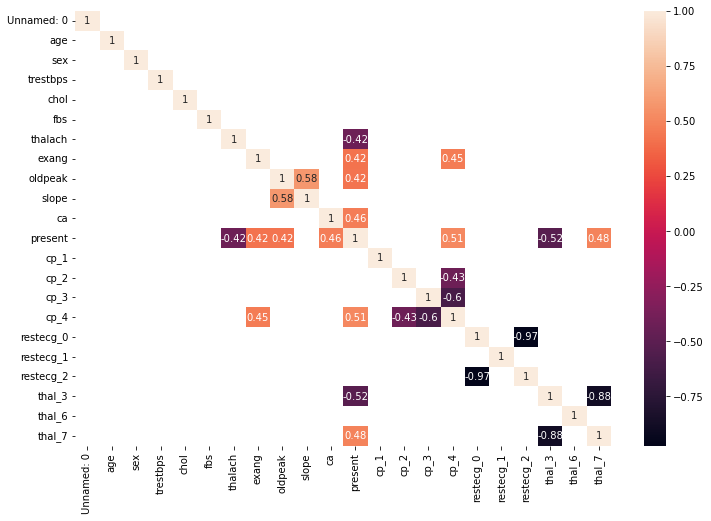

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(pearsons[abs(pearsons) > 0.4], annot=True)

The features `thalach`, `exang`, `oldpeak`, `slope`, `ca`, `cp_4`, `thal_3` and `thal_7` are well correlated with the target variable `present`. 
Stratifying these features by `present` offers more insights and is demonstrated visually by:

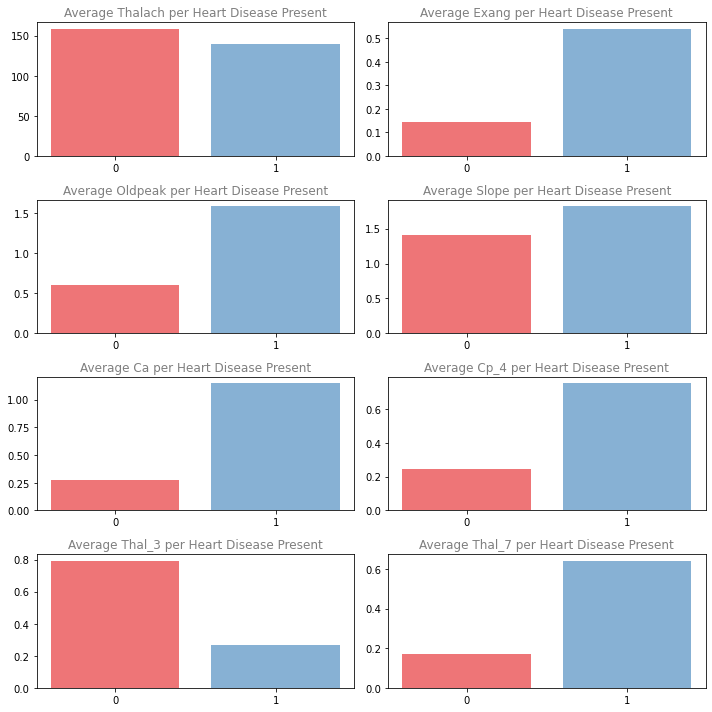

In [14]:
selected_features = ['thalach','exang','oldpeak','slope','ca','cp_4','thal_3','thal_7']

fig = plt.figure(figsize=(10, 10))

for i, feature in enumerate(selected_features):
    df_plot = df.groupby('present')[feature].mean()
    ax = fig.add_subplot(4, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {feature.title()} per Heart Disease Present', alpha=0.5)
    ax.xaxis.grid(False)
    ax.set_xticks([0,1])

plt.tight_layout()
plt.show()

Based on these plots and the aforementioned observations, the features `exang`, `oldpeak`, `ca`, `cp_4`, `thal_3` and `thal_7` are selected for predicting heart disease.

Looking at the distributions of these features, `exang` indicates to introduce bias into the prediction:

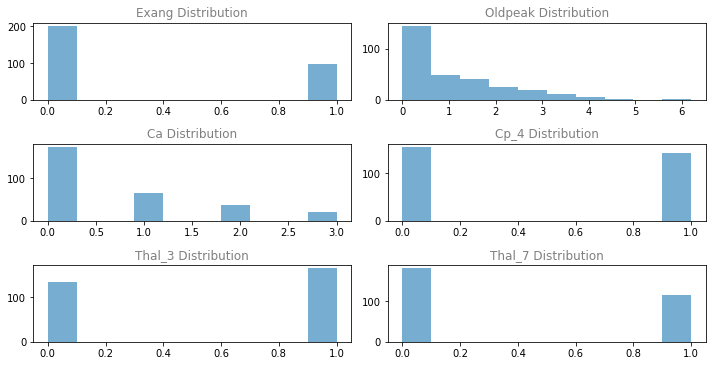

In [15]:
selected_features = ['exang','oldpeak','ca','cp_4','thal_3','thal_7']

fig = plt.figure(figsize=(10, 10))

for i, feature in enumerate(selected_features):
    df_plot = df.groupby('present')[feature].mean()
    ax = fig.add_subplot(6, 2, i+1)
    ax.hist(df[feature], alpha=0.6)
    ax.set_title(f'{feature.title()} Distribution', alpha=0.5)
    ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

Nonetheless, these features are chosen for prediction in the following steps.

## Dividing the Data

Now the dataset with the selected features is divided in a test and a training subset. Since the selected features are on the same scale standardization is not necessary.  The size of the test set is decided to be `20 %` of the original dataset:

In [16]:
X = df[selected_features]
y = df['present']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The distribution of cases and non_cases is well distributed over both datasets:

In [17]:
print(y_train.value_counts())
print(y_test.value_counts())

0    124
1    113
Name: present, dtype: int64
0    36
1    24
Name: present, dtype: int64


## Buildung the Model

The model is built and fitted on the training set:

In [18]:
model =  LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

The accuracy is `83 %` (proportion of the dataset which is predicted correctly):

In [19]:
model.score(X_train, y_train)

0.8312236286919831

The confusion matrix offers more insights:

In [20]:
train_predictions = model.predict(X_train)
confusion_matrix(y_train, train_predictions)

array([[109,  15],
       [ 25,  88]])

There are `15` false positives and `25` false negatives.
Based on these findings a sensitivity of `78 %` and a specificity of `88 %` is calculated. Consequently, non-cases are predicted better than cases. 

## Model Evaluation

The model is now evaluated based on the test set. The accuracy increases to `90 %`:

In [21]:
model.score(X_test, y_test)

0.9

Again, the confusion matrix is given by:

In [22]:
test_predictions = model.predict(X_test)
confusion_matrix(y_test, test_predictions)

array([[33,  3],
       [ 3, 21]])

There are `3` false positives and `3` false negatives, which gives a sensitivity of `88 %` and a specificity of `92 %`. In general, the dataset is generalized well by the model. There is no sign of overfitting.

## Summary

A linear logistic model for classifying heart disease is presented. The sensitivity is slightly better than the specificity, meaning non-cases are better predicted than cases. The reason for this might be the introduction of bias by the `exang` feature (where non-cases are over-represented). 

Nevertheless, the model generalizes the dataset well and shows a sound accuracy of `90 %`. 